In [1]:
from dask.distributed import Client

client = Client("tcp://10.32.16.170:39265")
client

Client Scheduler: tcp://10.32.16.170:39265 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 18 Cores: 36 Memory: 207.00 GB


# Volume-weighted T/S Diagram from WOA

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import xarray as xr
import gsw

In [3]:
ds_salt = xr.open_dataset('http://apdrc.soest.hawaii.edu:80/dods/public_data/WOA/WOA18/1_deg/annual/Avg_Decades_1981-2010/salt')
ds_temp = xr.open_dataset('http://apdrc.soest.hawaii.edu:80/dods/public_data/WOA/WOA18/1_deg/annual/Avg_Decades_1981-2010/temp')
ds = xr.merge([ds_salt, ds_temp])
ds

<xarray.Dataset>
Dimensions:  (lat: 180, lev: 102, lon: 360, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-15
  * lev      (lev) float64 0.0 5.0 10.0 15.0 ... 5.2e+03 5.3e+03 5.4e+03 5.5e+03
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables:
    san      (time, lev, lat, lon) float32 ...
    smn      (time, lev, lat, lon) float32 ...
    sdd      (time, lev, lat, lon) float32 ...
    ssd      (time, lev, lat, lon) float32 ...
    sse      (time, lev, lat, lon) float32 ...
    soa      (time, lev, lat, lon) float32 ...
    sgp      (time, lev, lat, lon) float32 ...
    tan      (time, lev, lat, lon) float32 ...
    tmn      (time, lev, lat, lon) float32 ...
    tdd      (time, lev, lat, lon) float32 ...
    tsd      (time, lev, lat, lon) float32 ...
    tse      (time, lev, lat, lon) float32 ...
    toa      (time, lev, lat, lon) float32 ...
    tgp      (time, lev, lat, lon) float32 ...

In [4]:
from xhistogram.xarray import histogram
from matplotlib.colors import LogNorm

In [5]:
lower_lat = -79.88
upper_lat = -59.88
left_lon = -74.88
right_lon = 30.12

In [6]:
#set the boundaries
lat_range = dict(lat=slice(lower_lat, upper_lat))
lon_range = dict(lon=slice(left_lon, right_lon))

In [7]:
temp = ds.tan.sel(**lat_range, **lon_range)
salt = ds.san.sel(**lat_range, **lon_range)

In [8]:
# Create a dz variable
dz = np.diff(ds.lev)
dz = np.insert(dz, 0, dz[0]) #inserts 1st value of original dz into the first index to make it same size as ds.lev
dz = xr.DataArray(dz, coords= {'lev':ds.lev}, dims='lev')

In [9]:
dlat = np.diff(ds.lat)[0]

# check that spacing is uniform
np.testing.assert_allclose(np.diff(ds.lat), dlat)
dlon = np.diff(ds.lon)[0]
np.testing.assert_allclose(np.diff(ds.lon), dlon)
(dlon, dlat)

(1.0, 1.0)

In [11]:
rad_earth = 6378.1e3 #meters

#create a dy variable
dy = rad_earth * np.deg2rad(dlat)
dy

111318.84502145034

In [12]:
#create a dx variable
dx = rad_earth * np.deg2rad(dlon) * np.cos(np.deg2rad(ds.lat))

In [13]:
area, _, _ = xr.broadcast(dx * dy, ds.lat, ds.lon)
area

<xarray.DataArray 'lat' (lat: 180, lon: 360)>
array([[1.08138227e+08, 1.08138227e+08, 1.08138227e+08, ...,
        1.08138227e+08, 1.08138227e+08, 1.08138227e+08],
       [3.24381740e+08, 3.24381740e+08, 3.24381740e+08, ...,
        3.24381740e+08, 3.24381740e+08, 3.24381740e+08],
       [5.40526443e+08, 5.40526443e+08, 5.40526443e+08, ...,
        5.40526443e+08, 5.40526443e+08, 5.40526443e+08],
       ...,
       [5.40526443e+08, 5.40526443e+08, 5.40526443e+08, ...,
        5.40526443e+08, 5.40526443e+08, 5.40526443e+08],
       [3.24381740e+08, 3.24381740e+08, 3.24381740e+08, ...,
        3.24381740e+08, 3.24381740e+08, 3.24381740e+08],
       [1.08138227e+08, 1.08138227e+08, 1.08138227e+08, ...,
        1.08138227e+08, 1.08138227e+08, 1.08138227e+08]])
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5

In [14]:
dV = area * dz
dV_wg = dV.sel(**lat_range, **lon_range)

In [21]:
#salt_bins = np.linspace(33, 35, 100)
#theta_bins = np.linspace(-2.2, 4.2, 100)

salt_bins = np.linspace(31, 35, 100) #to match model bins
theta_bins = np.linspace(-2.5, 8, 100) #to match model bins

delta_salt = salt_bins[1] - salt_bins[0]
delta_theta = theta_bins[1] - theta_bins[0]

In [26]:
# open an issue on xhistogram that describes this error when not using [0]
# xhistogram should be able to deal with it fine
# (use synthetic example, not real data)
ts_hist_8110 = histogram(temp[0], salt[0], 
                    bins=[theta_bins, salt_bins], 
                    weights=dV_wg,
                    dim=['lon', 'lat', 'lev']) / (delta_salt * delta_theta)

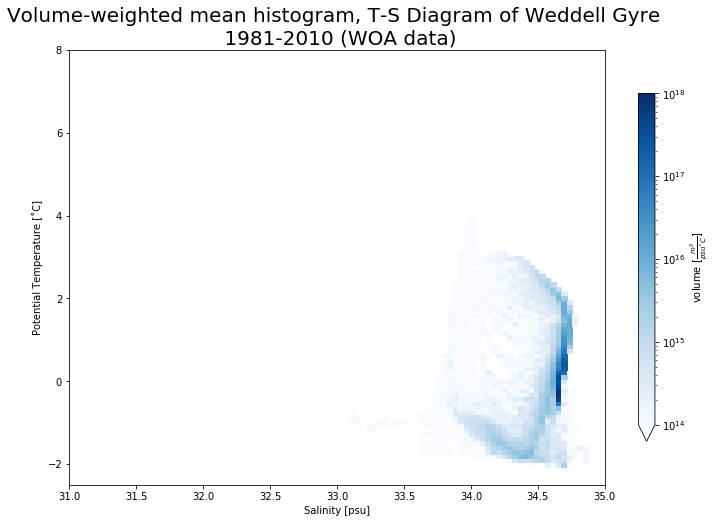

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/utils.py", line 663, in log_errors
    yield
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/client.py", line 1296, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/utils.py", line 663, in log_errors
    yield
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/client.py", line 1025, in _reconnect
    await self._close()
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/client.py", line 1296, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures

In [27]:
ts_hist_8110.where(ts_hist_8110>0).plot(norm=LogNorm(), figsize=(12,8), cmap='Blues',
                              cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'},
                              vmin=1e14, vmax=1e18)

plt.xlabel('Salinity [psu]')
plt.ylabel('Potential Temperature [˚C]')
plt.title('Volume-weighted mean histogram, T-S Diagram of Weddell Gyre \n 1981-2010 (WOA data)', fontsize=20);

* You can take the difference between the scatter plots (ex: SOSE-WOA) and compare does the model have enough points
* this is a naive way - there is no weights involved, you have to figure that out yourself for WOA data - refer back to notes in Slack by Ryan and maybe xgcm package by Julius

## 2005 - 2017

In [17]:
ds_salt_0517 = xr.open_dataset('http://apdrc.soest.hawaii.edu:80/dods/public_data/WOA/WOA18/1_deg/annual/2005-2017/salt')
ds_temp_0517 = xr.open_dataset('http://apdrc.soest.hawaii.edu:80/dods/public_data/WOA/WOA18/1_deg/annual/2005-2017/temp')
ds_0517 = xr.merge([ds_salt_0517, ds_temp_0517])
ds_0517

<xarray.Dataset>
Dimensions:  (lat: 180, lev: 102, lon: 360, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-15
  * lev      (lev) float64 0.0 5.0 10.0 15.0 ... 5.2e+03 5.3e+03 5.4e+03 5.5e+03
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables:
    san      (time, lev, lat, lon) float32 ...
    smn      (time, lev, lat, lon) float32 ...
    sdd      (time, lev, lat, lon) float32 ...
    ssd      (time, lev, lat, lon) float32 ...
    sse      (time, lev, lat, lon) float32 ...
    soa      (time, lev, lat, lon) float32 ...
    sgp      (time, lev, lat, lon) float32 ...
    tan      (time, lev, lat, lon) float32 ...
    tmn      (time, lev, lat, lon) float32 ...
    tdd      (time, lev, lat, lon) float32 ...
    tsd      (time, lev, lat, lon) float32 ...
    tse      (time, lev, lat, lon) float32 ...
    toa      (time, lev, lat, lon) float32 ...
    tgp      (time, lev, lat, lon) float32 ...

In [18]:
temp_0517 = ds_0517.tan.sel(**lat_range, **lon_range)
salt_0517 = ds_0517.san.sel(**lat_range, **lon_range)

In [24]:
ts_hist_0517 = histogram(temp_0517[0], salt_0517[0], 
                         bins=[theta_bins, salt_bins],
                         weights=dV_wg,
                         dim=['lon', 'lat', 'lev']) / (delta_salt * delta_theta)

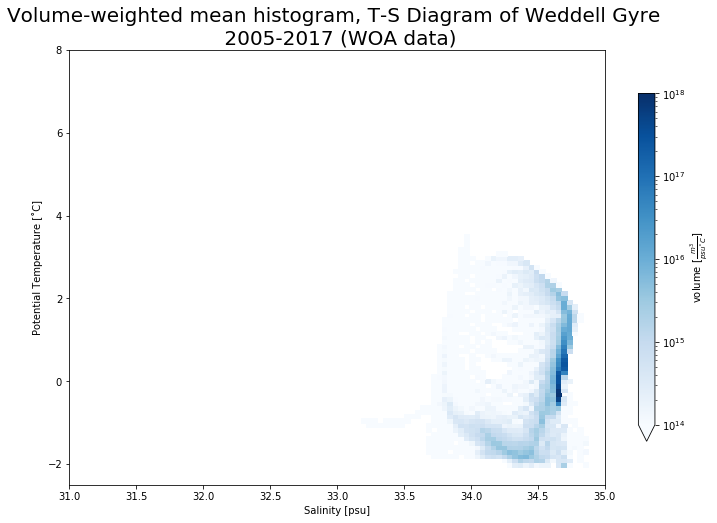

In [24]:
ts_hist_0517.where(ts_hist_0517>0).plot(norm=LogNorm(), figsize=(12,8), cmap='Blues',
                                        cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'},
                                        vmin=1e14, vmax=1e18)

plt.xlabel('Salinity [psu]')
plt.ylabel('Potential Temperature [˚C]')
plt.title('Volume-weighted mean histogram, T-S Diagram of Weddell Gyre \n 2005-2017 (WOA data)', fontsize=20);